# <center><font color='red'> TME 1 - Problèmes de Bandits </font></center>

Ce TME a pour objectif d'expérimenter les modèles UCB et LinUCB vus en cours pour de la sélection de publicité en ligne.

## 1. Données


Un fichier de données pour la sélection de publicité en ligne a été préparé pour expérimenter
les modèles : CTR.txt, télchargeable sur le site de l'UE. Ce fichier contient les contextes (profils d'articles) et les taux de clic sur les publicités de 10 annonceurs pour 5000 articles (1 par ligne): <br>
<*numero de l'article*> : <*représentation de l'article en 5 dimensions séparées par des ";"*> : <*taux de clics sur les publicités de 10 annonceurs séparés par des ";"*> <br>
Pour chaque visite, l'objectif est de choisir la publicité d'un des 10 annonceurs permettant d'engrenger le plus fort taux de clics.

In [2]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
ctr = pd.read_csv("CTR.txt", header = None, delimiter = "\s+|;|:", engine = "python")

contextes = ctr.iloc[:,1:6] # extraction des colonnes concernant les contextes
clics = ctr.iloc[:,6:16] # extraction des colonnes concernant les taux de clics

# renommage des noms de colonnes pour avoir un accès aux valeurs comme avec des indices
clics = clics.rename(columns={6: 0, 7: 1, 8:2, 9:3, 10:4, 11:5, 12:6, 13:7, 14:8, 15:9}) 
contextes = contextes.rename(columns={1:0, 2:1, 3:2, 4:3, 5:4})


## 2. Baselines

Trois baselines peuvent être envisagées :
<ul>
    <li> Stratégie Random : A chaque itération, on choisit n'importe quel annonceur </li>
    <li> Stratégie StaticBest : A chaque itération, on choisit l'annonceur avec le meilleur taux de clics cumulés </li>
    <li> Stratégie Optimale : A chaque iteration, on choisit l'annonceur qui a le meilleur taux de clics à cette itération </li>
    
</ul>

In [4]:
def baseline(clics, strat="Random"):
    obs = clics.shape[0]
    bandits = clics.shape[1]
    rewards = np.zeros(obs)
    
    if strat == "Random":
        for i in range(obs):
            selec = np.random.randint(0,bandits)
            rewards[i] = clics.iloc[i][selec]
            
    elif strat == "StaticBest":
        best_clics = clics.sum(0).idxmax()
        rewards = clics.iloc[:,best_clics]
           
    elif strat == "Optimale":
        for i in range(obs):
            selec = clics.iloc[i].idxmax()
            rewards[i] = clics.iloc[i][selec]
            
    else:
        print("Stratégie inconnue")
        
    return np.cumsum(rewards)

baseline_rand = baseline(clics)
baseline_staticBest = baseline(clics, "StaticBest")
baseline_opti = baseline(clics, "Optimale")

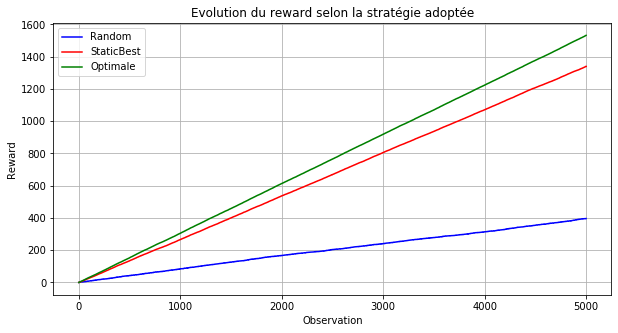

In [51]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid()
ax.set(xlabel='Observation', ylabel='Reward',
       title='Evolution du reward selon la stratégie adoptée')

plt.step(np.arange(len(baseline_rand)), baseline_rand, 'b', label="Random" )

plt.step(np.arange(len(baseline_staticBest)), baseline_staticBest, 'r', label="StaticBest" )

plt.step(np.arange(len(baseline_opti)), baseline_opti, 'g', label="Optimale" )

ax.legend()
plt.show()

# 3. UCB

Développer et expérimenter l'algorithme UCB vu en cours

In [8]:
def UCB(clics):
    obs = clics.shape[0]
    bandits = clics.shape[1]
    
    times_picked = np.ones(bandits) # ones instead of zeros to avoid division by zeros
    mu = np.zeros(bandits)
    rewards = np.zeros(obs)
    reward_per_arm = np.zeros(bandits)
    

    for i in range(bandits):
        reward = clics.iloc[i][i]
        reward_per_arm[i] += reward
        mu[i] = reward
    
    for t in range(obs):
        selec = np.argmax( mu + np.sqrt( (2*np.log(t+1)) / times_picked ) )
        reward = clics.iloc[t][selec]
        rewards[t] = reward
        times_picked[selec] += 1
        reward_per_arm[selec] += reward
        mu[selec] = reward_per_arm[selec] / times_picked[selec]
        
    return np.cumsum(rewards)
        
ucb = UCB(clics)

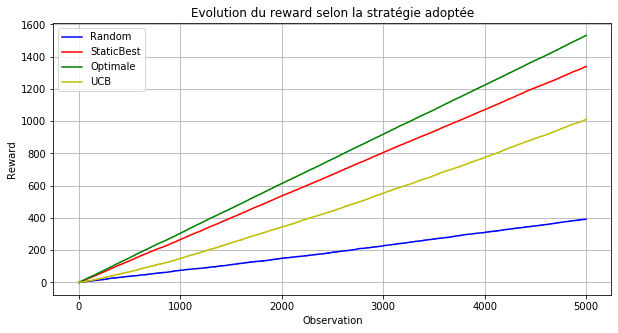

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid()
ax.set(xlabel='Observation', ylabel='Reward',
       title='Evolution du reward selon la stratégie adoptée')

plt.step(np.arange(len(baseline_rand)), baseline_rand, 'b', label="Random" )

plt.step(np.arange(len(baseline_staticBest)), baseline_staticBest, 'r', label="StaticBest" )

plt.step(np.arange(len(baseline_opti)), baseline_opti, 'g', label="Optimale" )

plt.step(np.arange(len(ucb)), ucb, 'y', label="UCB")

ax.legend()
plt.show()

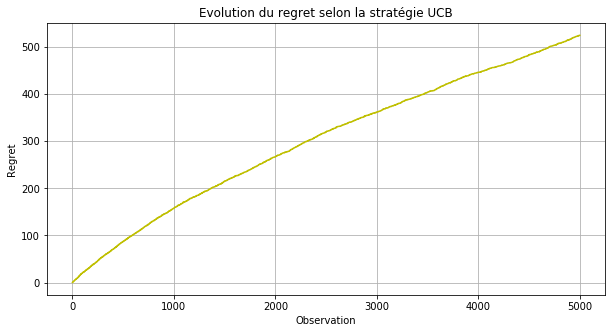

In [55]:
regret = baseline_opti - ucb

fig, ax = plt.subplots(figsize=(10, 5))
ax.grid()
ax.set(xlabel='Observation', ylabel='Regret',
       title='Evolution du regret selon la stratégie UCB')

plt.step(np.arange(len(regret)), regret, 'y')

plt.show()

# 4. LinUCB

Développer et expérimenter l'algorithme LinUCB vu en cours. Cet algorithme propose de prendre en compte le contexte de la décision, qui peut être très utile pour prévoir les variations des taux observés.

In [284]:
def linUCB(clics, contextes, alpha=0.1):
    obs = clics.shape[0]
    arms = clics.shape[1]
    d = contextes.shape[1]
    
    A = np.zeros((arms, d, d))
    for i in range(arms):
        A[i] = np.eye(d, d)
        
    b = np.zeros((arms, d, 1))

    theta = np.zeros((arms, d, 1))
    p = np.zeros(arms)
    rewards = np.zeros(obs)
    
    for t in range(obs):
        x = contextes.iloc[t]
        for a in range(arms):
            A_inv = np.linalg.inv(A[a])
            theta[a] = A_inv.dot(b[a])
            p[a] = theta[a].T.dot(x) + ( alpha * np.sqrt(x.T.dot(A_inv).dot(x)) ) 
            
        selec = np.argmax(p)
        reward = clics.iloc[t,selec]
        rewards[t] = reward
        A[selec] += x.dot(x.T)
        b[selec] += np.array(x*reward).reshape((5,1))
        
    return np.cumsum( rewards )

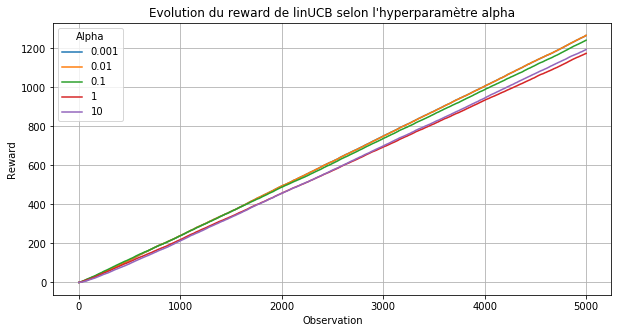

In [305]:
list_linUCB = []
alpha = [0.001, 0.01, 0.1, 1, 10]

for i in alpha:
    list_linUCB.append( linUCB(clics, contextes, i) )
    
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid()
ax.set(xlabel='Observation', ylabel='Reward',
       title="Evolution du reward de linUCB selon l'hyperparamètre alpha")

for i in range(len(list_linUCB)):
    plt.step(np.arange(len(list_linUCB[i])), list_linUCB[i], label = ""+str(alpha[i]))

ax.legend(title = "Alpha")
plt.show()

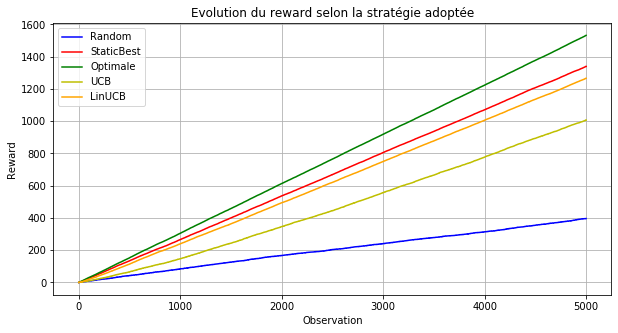

In [307]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid()
ax.set(xlabel='Observation', ylabel='Reward',
       title='Evolution du reward selon la stratégie adoptée')

plt.step(np.arange(len(baseline_rand)), baseline_rand, 'b', label="Random" )

plt.step(np.arange(len(baseline_staticBest)), baseline_staticBest, 'r', label="StaticBest" )

plt.step(np.arange(len(baseline_opti)), baseline_opti, 'g', label="Optimale" )

plt.step(np.arange(len(ucb)), ucb, 'y', label="UCB")

plt.step(np.arange(len(list_linUCB[0])), list_linUCB[0], 'orange', label="LinUCB")

ax.legend()
plt.show()

<font color="green"> Nous obtenons un meilleur reward en prenant en compte le contexte de la décision </font>

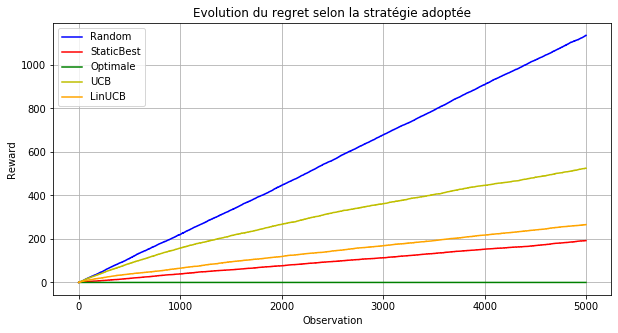

In [308]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid()
ax.set(xlabel='Observation', ylabel='Reward',
       title='Evolution du regret selon la stratégie adoptée')

plt.step(np.arange(len(baseline_rand)), baseline_opti - baseline_rand, 'b', label="Random" )

plt.step(np.arange(len(baseline_staticBest)), baseline_opti - baseline_staticBest, 'r', label="StaticBest" )

plt.step(np.arange(len(baseline_opti)), baseline_opti - baseline_opti, 'g', label="Optimale" )

plt.step(np.arange(len(ucb)), baseline_opti - ucb, 'y', label="UCB")

plt.step(np.arange(len(list_linUCB[0])), baseline_opti - list_linUCB[0], 'orange', label="LinUCB")

ax.legend()
plt.show()